```{contents}
```
## Semaphore

A **semaphore in LangGraph** is a **concurrency-control mechanism** that limits how many graph executions, nodes, or tasks are allowed to run **simultaneously**.
It prevents resource exhaustion, race conditions, and unstable execution in **parallel, agent-based, and production-grade systems**.

---

### **1. Why Semaphores Matter in LangGraph**

Modern LangGraph applications use:

* **Parallel nodes**
* **Multiple agents**
* **Async tool calls**
* **Concurrent user sessions**

Without limits, this causes:

* API rate limit violations
* Memory exhaustion
* CPU overload
* Cascading failures

A semaphore enforces **safe concurrency**.

---

### **2. Conceptual Model**

A semaphore maintains a **counter**:

| Value | Meaning |
| ----- | ------- |

> 0 | All slots used → wait |
> 1..N | Available execution slots |

```
Acquire Slot → Execute → Release Slot
```

If no slot is available, the task **waits**.

---

### **3. Where Semaphores Fit in LangGraph**

| Layer           | Usage                  |
| --------------- | ---------------------- |
| Graph Runtime   | Limit total graph runs |
| Node Execution  | Limit heavy nodes      |
| Tool Invocation | Rate-limit APIs        |
| Agent Systems   | Limit active agents    |
| Deployment      | Control tenant load    |

---

### **4. Practical Implementation Pattern**

LangGraph itself is **semaphore-compatible** with Python’s async model.

### **Global Semaphore for Graph Execution**

```python
import asyncio

semaphore = asyncio.Semaphore(3)  # max 3 concurrent runs

async def safe_invoke(graph, input):
    async with semaphore:
        return await graph.ainvoke(input)
```

---

### **Node-Level Semaphore**

```python
node_semaphore = asyncio.Semaphore(2)

async def expensive_node(state):
    async with node_semaphore:
        # heavy computation or API call
        result = await call_external_api()
        return {"result": result}
```

---

### **5. Production Example — Rate-Limited Tool**

```python
api_semaphore = asyncio.Semaphore(5)

async def tool_node(state):
    async with api_semaphore:
        response = await external_service(state["query"])
        return {"tool_result": response}
```

---

### **6. Semaphores with Parallel LangGraph Nodes**

```
           ┌── Worker A ──┐
Input ──► Router          ├─► Join ─► Output
           └── Worker B ──┘
```

Each worker uses the same semaphore:

```python
worker_semaphore = asyncio.Semaphore(2)
```

This ensures at most **2 workers across the entire graph** run concurrently.

---

### **7. Semaphore vs Other Controls**

| Mechanism       | Purpose                  |
| --------------- | ------------------------ |
| Semaphore       | Limit concurrency        |
| Lock            | Protect critical section |
| Queue           | Order execution          |
| Rate Limiter    | Limit requests per time  |
| Circuit Breaker | Stop on failures         |

Semaphore controls **capacity**, not correctness.

---

### **8. Common Production Use Cases**

| Scenario          | Why                         |
| ----------------- | --------------------------- |
| LLM API calls     | Prevent hitting rate limits |
| Vector DB writes  | Avoid overload              |
| File processing   | Control memory              |
| Agent swarms      | Prevent explosion           |
| Multi-tenant apps | Fair resource sharing       |

---

### **9. Failure & Safety Handling**

| Risk         | Mitigation               |
| ------------ | ------------------------ |
| Deadlock     | Always release semaphore |
| Starvation   | Fair scheduling          |
| Leak         | Use `async with`         |
| Backpressure | Combine with queues      |

---

### **10. Mental Model**

Think of a semaphore as a **toll booth** on your graph:

> **Only N cars can be on the highway at once.**

This transforms LangGraph from a fragile parallel system into a **stable production-grade execution engine**.



### Demonstration

In [2]:
import asyncio
from typing import TypedDict
from langgraph.graph import StateGraph, END

# -----------------------------
# Shared State Definition
# -----------------------------
class State(TypedDict):
    value: int
    result: int

# -----------------------------
# Global Semaphore (limit = 2)
# -----------------------------
semaphore = asyncio.Semaphore(2)

# -----------------------------
# Semaphore-Protected Node
# -----------------------------
async def heavy_compute(state: State):
    async with semaphore:
        print(f"Computing for input {state['value']}...")
        await asyncio.sleep(2)   # simulate heavy work
        return {"result": state["value"] ** 2}

# -----------------------------
# Build LangGraph
# -----------------------------
builder = StateGraph(State)
builder.add_node("compute", heavy_compute)
builder.set_entry_point("compute")
builder.add_edge("compute", END)
graph = builder.compile()

# -----------------------------
# Run Multiple Graph Invocations
# -----------------------------
async def run_many():
    tasks = []
    for i in range(6):
        tasks.append(graph.ainvoke({"value": i}))

    results = await asyncio.gather(*tasks)
    print("\nResults:", results)

await run_many()


Computing for input 0...
Computing for input 1...
Computing for input 2...
Computing for input 3...
Computing for input 4...
Computing for input 5...

Results: [{'value': 0, 'result': 0}, {'value': 1, 'result': 1}, {'value': 2, 'result': 4}, {'value': 3, 'result': 9}, {'value': 4, 'result': 16}, {'value': 5, 'result': 25}]


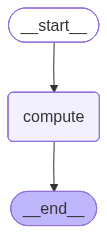

In [3]:
from IPython.display import Image
Image(graph.get_graph().draw_mermaid_png())